# Human Protein Atlas - Single Cell Classification EDA 

> Cells constitute the fundamental building blocks of all living organisms. Within human cells, proteins diligently execute specific functions within designated compartments known as organelles. The video "The Human Cell" by The Human Protein Atlas elaborates on this intricate cellular activity. I'm employing an Exploratory Data Analysis (EDA) notebook to share key findings from the Human Protein Atlas - Single Cell Classification competition. Furthermore, I've prepared a distinct notebook featuring a baseline submission, accessible at this [link](https://www.kaggle.com/thedrcat/hpa-baseline-cell-segmentation).

# Table of Contents

1. [Data](#data)
   - Training data and submission files
   - Distribution of labels
   - Class combinations
2. [Images](#images)
   - Channels in the images
   - Merging channels
   - Visualization of individual classes
3. [Evaluation Metric](#metric)
4. [Competition Insights](#notes)
5. [Initial Solution for Quick Prototyping](#baseline)
6. [Approaches to the Solution](#solutions)
7. [Helpful References](#resources)
   - Datasets

# 1. Data <a class="anchor" id="data"></a>

I will start by exploring the training data, including images and the label distribution. More to come as I start studying the domain. 

In [1]:
!pip install ipyplot -q

import pandas as pd
import numpy as np
from fastai.vision.all import *
import ipyplot
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

path = Path('../input/hpa-single-cell-image-classification')
df_train = pd.read_csv(path/'train.csv')
df_sub = pd.read_csv(path/'sample_submission.csv')

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## 1.1. Training and submission files

Let's start by looking into the training csv. We get image id and label column, which contains the classes corresponding to each image. Looking at this data, it appears to be a multi-label classification challenge...

In [2]:
df_train.head()

,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


Upon examining the sample submission, it becomes evident that this task is not a conventional multi-label classification problem, but rather an instance segmentation task. Each image requires us to segment individual cells within it, determine the corresponding cell class, and submit information in a specific format, encompassing:

1. The class of each cell
2. Confidence level of the class prediction
3. Segmentation mask for each cell, encoded in a specific manner

The distinction between our training data, which entails image-level classes, and the task of predicting cell masks alongside their corresponding classes, defines this as a "weakly supervised multi-label classification problem." Organizers have also highlighted some significant points:

- Certain cells might be associated with multiple classes, necessitating separate predictions for each class using the same mask.
- The relevance of the confidence score was initially misunderstood, and it's not always fixed at 1. For a comprehensive understanding of the competition metric and the role of confidence scores, refer to [this insightful kernel](https://www.kaggle.com/its7171/map-understanding-with-code-and-its-tips).

To grasp how to create the prediction string encoding, you can explore the demonstration within my [baseline kernel](https://www.kaggle.com/thedrcat/hpa-baseline-cell-segmentation). This clarifies the methodology of handling this intricate task.

In [3]:
df_sub.head()

,ID,ImageWidth,ImageHeight,PredictionString
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
1,004a270d-34a2-4d60-bbe4-365fca868193,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
2,00537262-883c-4b37-a3a1-a4931b6faea5,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
3,00c9a1c9-2f06-476f-8b0d-6d01032874a2,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
4,0173029a-161d-40ef-af28-2342915b22fb,3072,3072,0 1 eNoLCAgIsAQABJ4Beg==


In [4]:
train_path = path/'train'
train_images = train_path.ls()

In [5]:
len(df_train), len(train_images), len(train_images)/len(df_train)

(21806, 87224, 4.0)

Additionally, it's important to note that within the training folder, there exist four images for every image ID, corresponding to distinct channels: red, blue, green, and yellow. The official description elaborates on this:

> Each sample comprises four files, each representing a unique filter applied to the subcellular protein patterns depicted in the sample. The file format should be [filename]_[filter color].png for PNG files. The color associations are as follows: red for microtubule channels, blue for nuclei channels, yellow for Endoplasmic Reticulum (ER) channels, and green for the protein of interest.

## 1.2. Labels distribution

Let's first check how many unique labels we have in the dataset.

In [6]:
all_labels = df_train.Label.unique().tolist()
all_labels = '|'.join(all_labels)
all_labels = all_labels.split('|')
all_labels = list(set(all_labels))
num_unique_labels = len(all_labels)
all_labels = sorted(all_labels, key=int)
all_labels = ' '.join(all_labels)
print(f'{num_unique_labels} unique labels, values: {all_labels}')

19 unique labels, values: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18


Ok, so we have 19 unique labels from 0 to 18. What is the distribution of these labels? I wonder especially how many images have only one label (unique counts) and what is the overall number of images for each label? Looking at the chart below, we can see it's an imbalanced dataset and labels 11 and 18 are going to be especially problematic. 

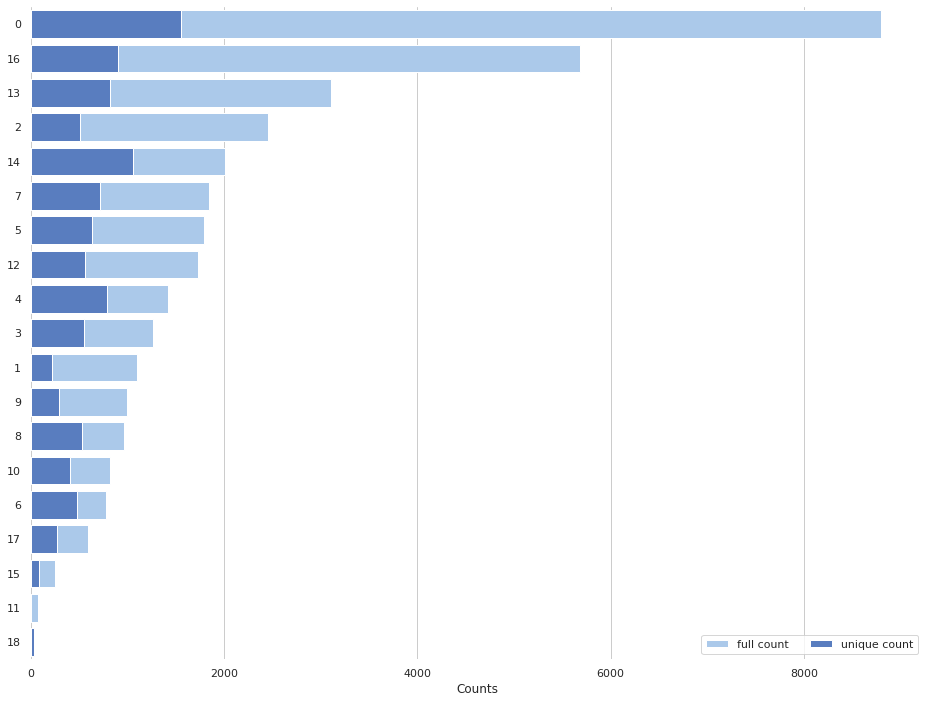

In [7]:
labels = [str(i) for i in range(19)]

unique_counts = {}
for lbl in labels:
    unique_counts[lbl] = len(df_train[df_train.Label == lbl])

full_counts = {}
for lbl in labels:
    count = 0
    for row_label in df_train['Label']:
        if lbl in row_label.split('|'): count += 1
    full_counts[lbl] = count
    
counts = list(zip(full_counts.keys(), full_counts.values(), unique_counts.values()))
counts = np.array(sorted(counts, key=lambda x:-x[1]))
counts = pd.DataFrame(counts, columns=['label', 'full_count', 'unique_count'])

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(16, 12))

sns.set_color_codes("pastel")
sns.barplot(x="full_count", y="label", data=counts, order=counts.label.values,
            label="full count", color="b", orient = 'h')

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="unique_count", y="label", data=counts, order=counts.label.values,
            label="unique count", color="b", orient = 'h')

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="Counts")
sns.despine(left=True, bottom=True)

What do these labels represent? The descriptions below are taken from [this notebook shared by the organizers](https://www.kaggle.com/lnhtrang/single-cell-patterns).

| Label | Name | Description |
|-|-|-|
| 0. | Nucleoplasm | The nucleus is found in the center of cell and can be identified with the help of the signal in the blue nucleus channel. A staining of the nucleoplasm may include the whole nucleus or of the nucleus without the regions known as nucleoli (Class 2). |
| 1. | Nuclear membrane | The nuclear membrane appears as a thin circle around the nucleus. It is not perfectly smooth and sometimes it is also possible to see the folds of the membrane as small circles or dots inside the nucleus. |
| 2. | Nucleoli | Nucleoli can be seen as slightly elongated circular areas in the nucleoplasm, which usually display a much weaker staining in the blue DAPI channel. The number and size of nucleoli varies between cell types. |
| 3. | Nucleoli fibrillar center | Nucleoli fibrillary center can appear as a spotty cluster or as a single bigger spot in the nucleolus, depending on the cell type. |
| 4. | Nuclear speckles | Nuclear speckles can be seen as irregular and mottled spots inside the nucleoplasm. |
| 5. | Nuclear bodies | Nuclear bodies are visible as distinct spots in the nucleoplasm. They vary in shape, size and numbers depending on the type of bodies as well as cell type, but are usually more rounded compared to nuclear speckles. |
| 6. | Endoplasmic reticulum | The endoplasmic reticulum (ER) is recognized by a network-like staining in the cytosol, which is usually stronger close to the nucleus and weaker close to the edges of the cell. The ER can be identified with the help of the staining in the yellow ER channel. |
| 7. | Golgi apparatus | The Golgi apparatus is a rather large organelle that is located next to the nucleus, close to the centrosome, from which the microtubules in the red channel originate. It has a folded ribbon-like appearance, but the shape and size can vary between cell types, and in response to cellular various processes. |
| 8. | Intermediate filaments | Intermediate filaments often exhibit a slightly tangled structure with strands crossing every so often. They can appear similar to microtubules, but do not match well with the staining in the red microtubule channel. Intermediate filaments may extend through the whole cytosol, or be concentrated in an area close to the nucleus. |
| 9. | Actin filaments | Actin filaments can be seen as long and rather straight bundles of filaments or as branched networks of thinner filaments. They are usually located close to the edges of the cells. |
| 10. | Microtubules | Microtubules are seen as thin strands that stretch throughout the whole cell. It is almost always possible to detect the center from which they all originate (the centrosome). And yes, as you might have guessed, this overlaps the staining in the red channel. |
| 11. | Mitotic spindle | The mitotic spindle can be seen as an intricate structure of microtubules radiating from each of the centrosomes at opposite ends of a dividing cell (mitosis). At this stage, the chromatin of the cell is condensed, as visible by intense DAPI staining. The size and exact shape of the mitotic spindle changes during mitotic progression, clearly reflecting the different stages of mitosis. |
| 12. | Centrosome | This class includes centrosomes and centriolar satellites. They can be seen as a more or less distinct staining of a small area at the origin of the microtubules, close to the nucleus. When a cell is dividing, the two centrosomes move to opposite ends of the cell and form the poles of the mitotic spindle. |
| 13. | Plasma membrane | This class includes plasma membrane and cell junctions. Both are at the outer edge of the cell. Plasma membrane sometimes appears as a more or less distinct edge around the cell, occasionally with characteristic protrusions or ruffles. In some cell lines, the staining can be uniform across the entire cell. Cell junctions can be observed at contact sites between neighboring cells. |
| 14. | Mitochondria | Mitochondria are small rod-like units in the cytosol, which are often distributed in a thread-like pattern along microtubules. |
| 15. | Aggresome | An aggresome can be seen as a dense cytoplasmic inclusion, which is usually found close to the nucleus, in a region where the microtubule network is disrupted. |
| 16. | Cytosol | The cytosol extends from the plasma membrane to the nuclear membrane. It can appear smooth or granular, and the staining is often stronger close to the nucleus. |
| 17. | Vesicles and punctate cytosolic patterns | This class includes small circular compartments in the cytosol: Vesicles, Peroxisomes (lipid metabolism), Endosomes (sorting compartments), Lysosomes (degradation of molecules or eating up dead molecules), Lipid droplets (fat storage), Cytoplasmic bodies (distinct granules in the cytosol). They are highly dynamic, varying in numbers and size in response to environmental and cellular cues. They can be round or more elongated. |
| 18. | Negative | This class include negative stainings and unspecific patterns. This means that the cells have no green staining (negative), or have staining but no pattern can be deciphered from the staining (unspecific). |

Ok, so the class 18 which we found with very few examples is actually the "everything else" category - this can influence our labeling strategy. 

## 1.3. Combinations of classes

We already have a feeling for the volume of images with a single class. What do the combinations of these classes look like? 

In [8]:
print(f'Number of unique combinations of classes in the train set: {len(df_train.Label.value_counts())}')

Number of unique combinations of classes in the train set: 432


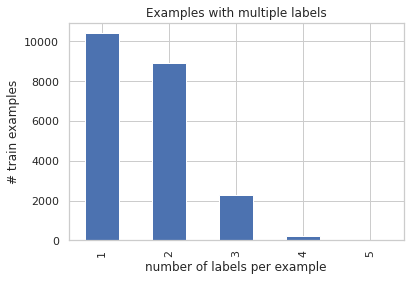

In [9]:
df_train['num_classes'] = df_train['Label'].apply(lambda r: len(r.split('|')))
df_train['num_classes'].value_counts().plot.bar(title='Examples with multiple labels', xlabel='number of labels per example', ylabel='# train examples')
plt.show()

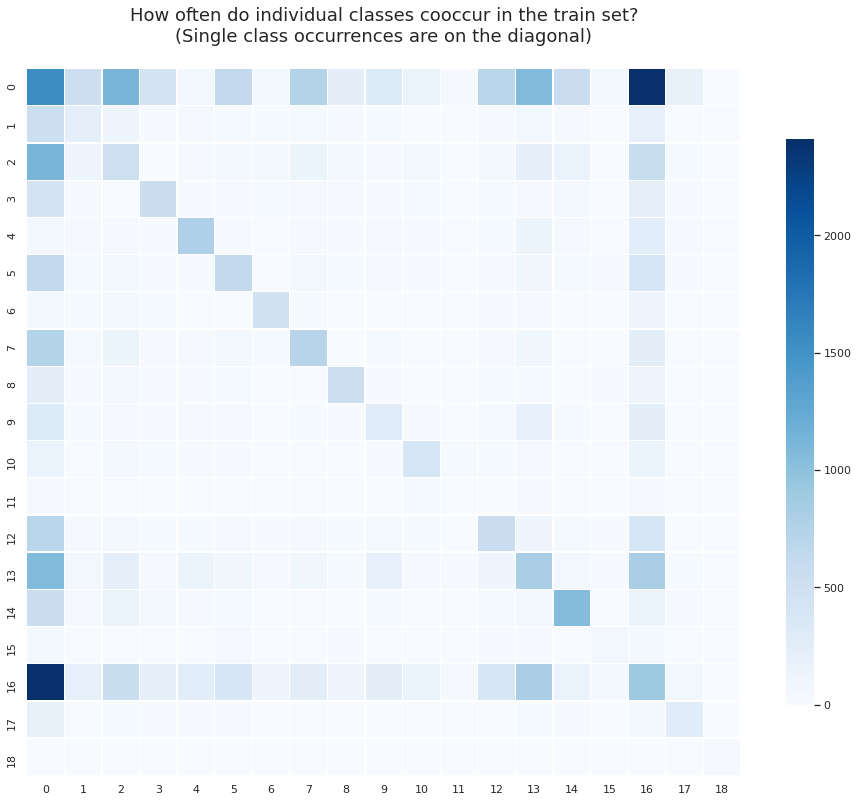

In [10]:
for x in labels: df_train[x] = df_train['Label'].apply(lambda r: int(x in r.split('|')))

df_labels = df_train[labels]
coocc = df_labels.T.dot(df_labels)
for i in range(19): coocc.iloc[i,i] = int(counts.unique_count[counts.label == str(i)].values[0])

fig, ax = plt.subplots(figsize=(16, 13))
sns.heatmap(coocc, cmap="Blues", linewidth=0.3, cbar_kws={"shrink": .8})
title = 'How often do individual classes cooccur in the train set?\n(Single class occurrences are on the diagonal)\n'
plt.title(title, loc='center', fontsize=18)
plt.show()

We can see from the coocurrence plot that the classes 0 (nucleoplasm) and 16 (cytosol) tend to cooccur most frequently with other classes, and especially with each other. These are also the most frequent classes.

In [11]:
# # I'll try another approach where we normalize the frequencies and compare them to random distribution based on class weights. 
# label_probs = counts.full_count.values.astype(int)/counts.full_count.values.astype(int).sum()
# label_probs = np.expand_dims(label_probs, axis=0)
# lprobs = label_probs.T @ label_probs
# df_probs = pd.DataFrame(lprobs, columns=labels)

# coocc_new = coocc.copy().astype(float)
# coocc_new = coocc_new.reset_index(drop=True)
# for i, row in coocc_new.iterrows():
# #     total = row.values.sum()
#     for j in range(len(row)):
#         row[j] /= len(df_train)

# norm_cooc = coocc_new - df_probs

# fig, ax = plt.subplots(figsize=(16, 13))
# sns.heatmap(norm_cooc, cmap="Blues", linewidth=0.3, cbar_kws={"shrink": .8})
# title = 'Actual vs expected class coocurrence\n'
# plt.title(title, loc='center', fontsize=18)
# plt.show()

# 2. Images <a class="anchor" id="images"></a>

## 2.1. Channels

In [12]:
mt = [path/'train'/(id+'_red.png') for id in df_train.ID.values]
er = [path/'train'/(id+'_yellow.png') for id in df_train.ID.values]
nu = [path/'train'/(id+'_blue.png') for id in df_train.ID.values]
pr = [path/'train'/(id+'_green.png') for id in df_train.ID.values]
images = [mt, er, nu, pr]
titles = ['microtubules', 'endoplasmic reticulum', 'nucleus', 'protein of interest']

Let's again try to understand the image data provided, and see if we can visualize it. All images have 4 channels: 
- Red (Microtubules)
- Green (Protein of interest)
- Blue (Nucleus)
- Yellow (Endoplasmic reticulum)

What does [Wikipedia](https://en.wikipedia.org/wiki/Cytoskeleton) tell us these channels represent?
- **Microtubules** are polymers of tubulin that form part of the cytoskeleton and provide structure and shape to eukaryotic cells. Microtubules can grow as long as 50 micrometres and are highly dynamic. The microtubule cytoskeleton is involved in the transport of material within cells, carried out by motor proteins that move on the surface of the microtubule. They are involved in maintaining the structure of the cell and, together with microfilaments and intermediate filaments, they form the cytoskeleton...
- **Nucleus** is a membrane-bound organelle found in eukaryotic cells. Eukaryotes usually have a single nucleus, but a few cell types, such as mammalian red blood cells, have no nuclei, and a few others including osteoclasts have many. The cell nucleus contains all of the cell's genome, except for the small amount of mitochondrial DNA. The nucleus maintains the integrity of genes and controls the activities of the cell by regulating gene expression. The nucleus is, therefore, the control center of the cell.
- The **endoplasmic reticulum** (ER) is, in essence, the transportation system of the eukaryotic cell, and has many other important functions such as protein folding. It is a type of organelle made up of two subunits – rough endoplasmic reticulum (RER), and smooth endoplasmic reticulum (SER). The endoplasmic reticulum is found in most eukaryotic cells and forms an interconnected network of flattened, membrane-enclosed sacs known as cisternae (in the RER), and tubular structures in the SER.
- **Protein of interest** - I still need to understand this better, I assume the researchers are interested in certain types of proteins, which are not disclosed, and these proteins are marked in this channel.

Let's see an example of each channel below. 

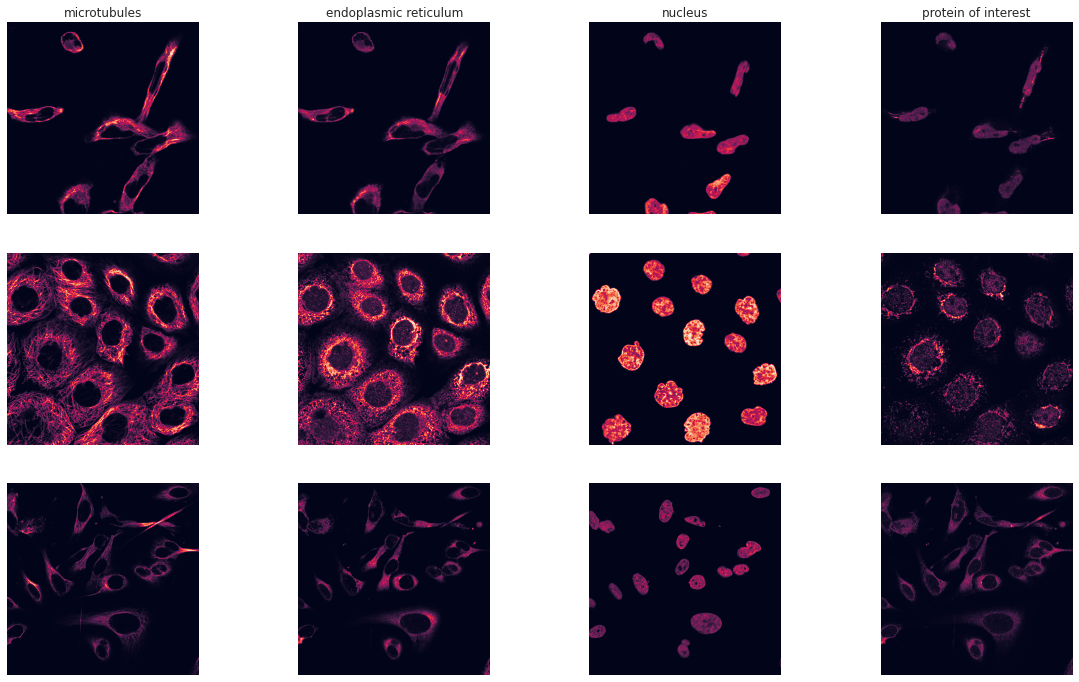

In [13]:
fig, ax = plt.subplots(3,4, figsize=(20,12))
for j in range(3):
    for i in range(4):
        img = plt.imread(images[i][j])
        if j == 0: ax[j,i].set_title(titles[i])
        ax[j,i].imshow(img)
        ax[j,i].axis('off')
plt.show()

## 2.2. Combining Channels

These are 4 channels, how do we display them in a single image? According to a comment from competition host, [we could blend them](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/214603). Looking at the notebook shared by the hosts, they visualize using 3 channels: red, yellow, blue. Let's see how it looks. 

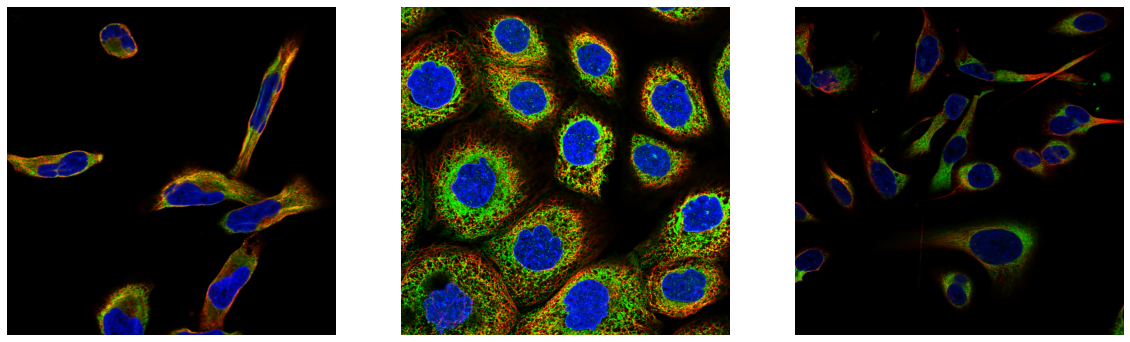

In [14]:
fig, ax = plt.subplots(1,3, figsize=(20,50))
for i in range(3):
    microtubule = plt.imread(mt[i])    
    endoplasmicrec = plt.imread(er[i])    
    nuclei = plt.imread(nu[i])
    img = np.dstack((microtubule, endoplasmicrec, nuclei))
    ax[i].imshow(img)
    ax[i].axis('off')
plt.show()

What if we visualize the red, green and blue channels instead? 

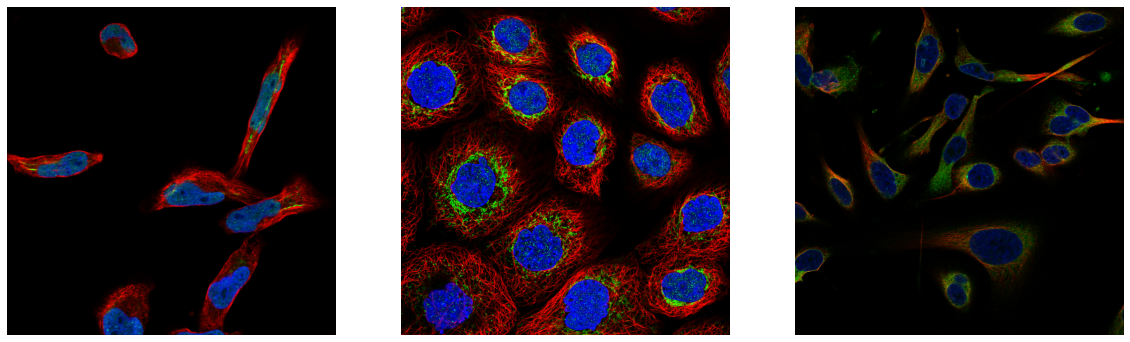

In [15]:
fig, ax = plt.subplots(1,3, figsize=(20,50))
for i in range(3):
    microtubule = plt.imread(mt[i])    
    protein = plt.imread(pr[i])    
    nuclei = plt.imread(nu[i])
    img = np.dstack((microtubule, protein, nuclei))
    ax[i].imshow(img)
    ax[i].axis('off')
plt.show()

Ok, these look similar. I'll explore the blending later on, for now let's stick with the organizers' approach.

## 2.3. Visualize single classes

In the following section I'd like to visualize an image for each class (only images representing single class).

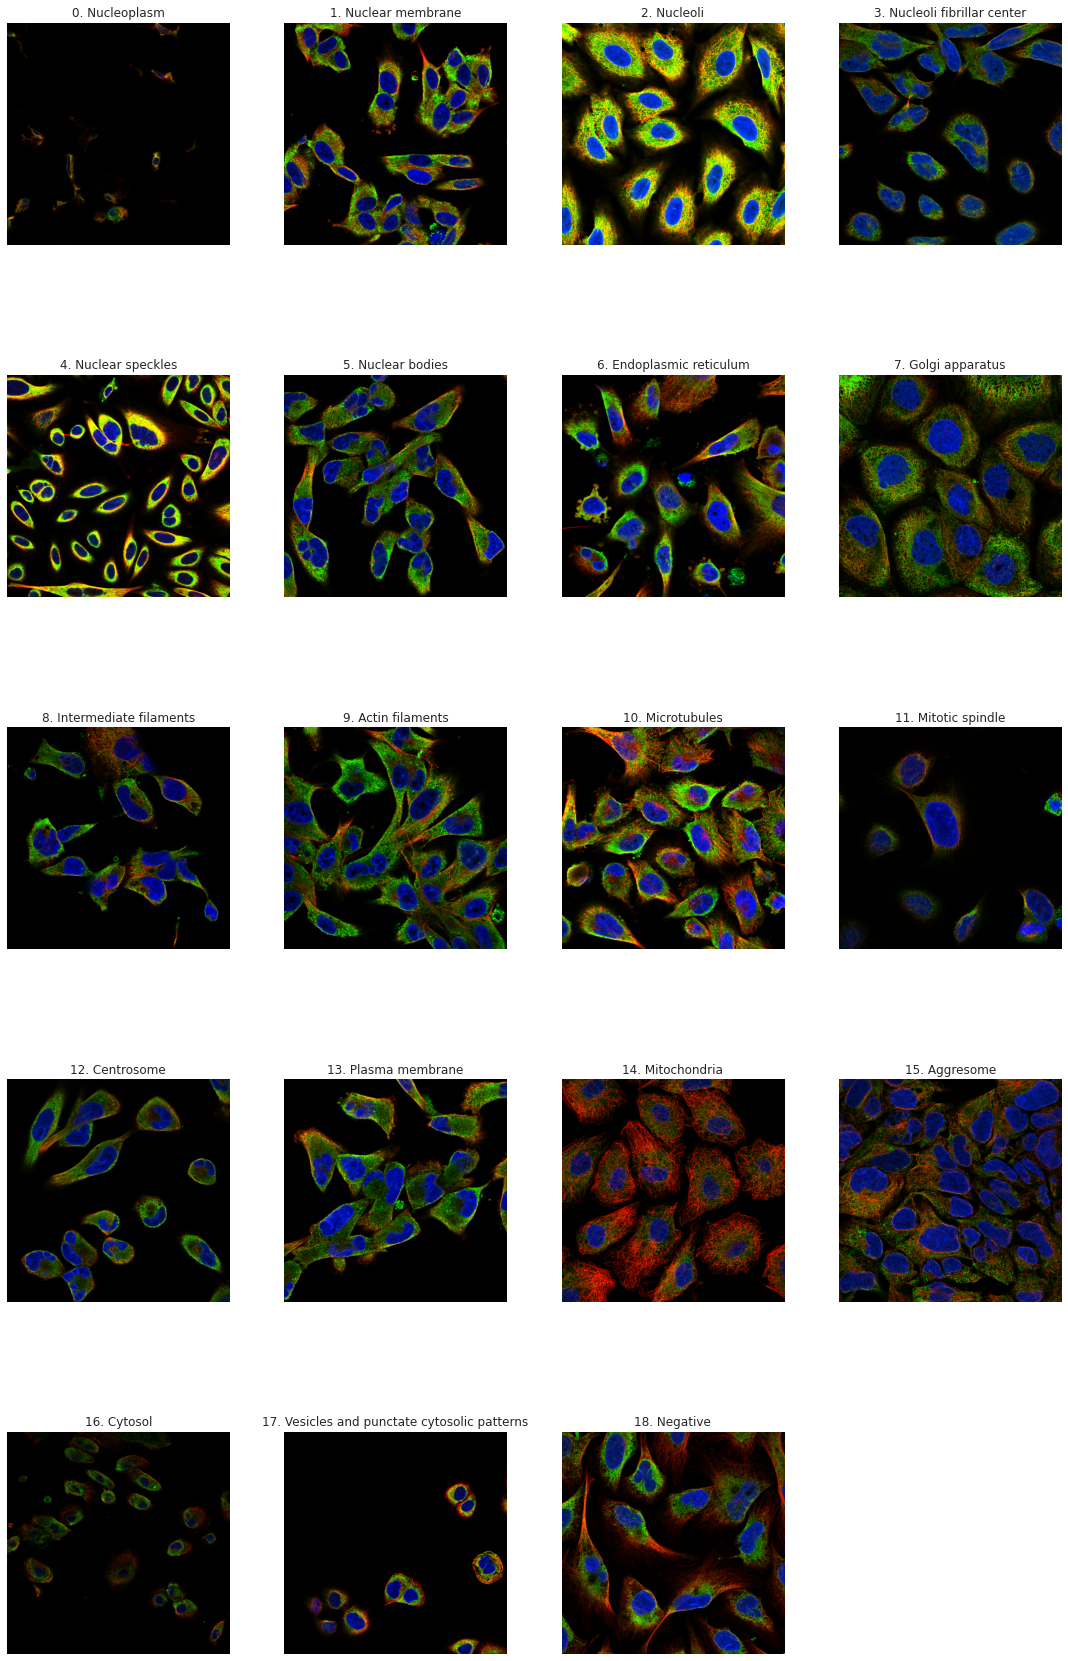

In [16]:
import imageio
from fastai.vision.all import PILImage
import numpy as np
import matplotlib.pyplot as plt
import math

codes = [
    '0. Nucleoplasm',
    '1. Nuclear membrane',
    '2. Nucleoli',
    '3. Nucleoli fibrillar center',
    '4. Nuclear speckles',
    '5. Nuclear bodies',
    '6. Endoplasmic reticulum',
    '7. Golgi apparatus',
    '8. Intermediate filaments',
    '9. Actin filaments',
    '10. Microtubules',
    '11. Mitotic spindle',
    '12. Centrosome',
    '13. Plasma membrane',
    '14. Mitochondria',
    '15. Aggresome',
    '16. Cytosol',
    '17. Vesicles and punctate cytosolic patterns',
    '18. Negative'
]

# Assuming you have loaded your data and defined the necessary variables

# Limit the number of images to display
max_images = 19

# Calculate the number of rows and columns for the grid layout
num_rows = int(math.ceil(max_images / 4))
num_cols = min(max_images, 4)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))  # Increase the figsize

for idx, label in enumerate(labels[:max_images]):
    r_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_red.png'
    y_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_yellow.png'
    b_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_blue.png'
    r = imageio.imread(path/'train'/r_img)
    y = imageio.imread(path/'train'/y_img)
    b = imageio.imread(path/'train'/b_img)
    rgb = np.dstack((r, y, b))
    pil_image = PILImage.create(rgb)

    label_index = int(label)  # Convert the label to an integer
    label_text = codes[label_index]

    row_idx = idx // num_cols
    col_idx = idx % num_cols
    ax = axes[row_idx, col_idx]
    ax.imshow(pil_image)
    ax.set_title(label_text)
    ax.axis('off')

# Remove any empty subplots
for i in range(max_images, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


# 3. Evaluation Metric <a class="anchor" id="metric"></a>

The evaluation metric for this competition has undergone changes. It functions as follows:

For each image, the predicted masks are compared against the ground-truth masks. Subsequently, the mean Average Precision (mAP) is computed. Instances where the model erroneously predicts class 0 for a given cell or predicts a class in a region of the image that doesn't correspond to a cell contribute to the False Positive count for that specific class. More information about this metric can be found in [this discussion](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/214659).